In [1]:
from hashlib import new
from lib2to3.pgen2.pgen import DFAState
from tempfile import TemporaryFile
import pandas as pd
import sys
import os
from dateutil.parser import parse
import time
import numpy as np
import json
import re
from pprint import pprint 
from psycopg2 import connect
from more_itertools import locate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import md_column_matching_table
import joblib
import warnings
warnings.filterwarnings("ignore")

## 인자값 입력
### 예측에 활용할, 저장된 학습모델 선택 (사용자 설정: MODEL FILENAME 입력)

In [2]:
col='BMS_SOC-Percent|BMS_HVPackCurrent-A|BMS_HVPackVoltage-V|MCU_MotorSpeed-rpm|BMS_Temp1-C|BMS_Temp2-C|BMS_Cell_1-V|BMS_MaxChargablePower-kW|BMS_InverterCapacityVolt-V'
col = list(col.split("|"))
ts='Date_new'
target='target_slow'

#########################################
# 저장된 학습모델 파일명
# 사용자 입력 MODEL_FILENAME
model_filename='MD_model'
#########################################

## (사용자 설정 디렉토리 내) 예측/판단 대상 파일 리스트 추출

In [3]:
#########################################
# 예측/판단 대상 파일 디렉토리 설정
path='MD_demo_test_data'
#########################################

def recursive_search_dir(_nowDir, _filelist):
    print(" [loop] recursive searching ", _nowDir, '\n')

    if os.path.isfile(_nowDir):
        _filelist.append(_nowDir)
        return None

    dir_list = []  # 현재 디렉토리의 서브디렉토리가 담길 list
    
    f_list = os.listdir(_nowDir)
    for fname in f_list:
        if os.path.isdir(_nowDir + "/" + fname):
            dir_list.append(_nowDir + "/" + fname)
        elif os.path.isfile(_nowDir + "/" + fname):
            _filelist.append(_nowDir + "/" + fname)

    for toDir in dir_list:
        recursive_search_dir(toDir, _filelist)

file_list = []
recursive_search_dir(path, file_list)

if len(file_list) == 0:      
    exit('\n\"' + _path + '\" 경로에 파일이 없습니다. 데이터셋이 있는지 확인해주세요.')
    
print(file_list)

 [loop] recursive searching  MD_demo_test_data 

['MD_demo_test_data/MD_2021_dataset.csv']


## CSV 파일을 데이터프레임으로 변환

In [4]:
colm = [ts, target]
colm = col + colm
all_df = []

for file in file_list:
    f_extension = os.path.splitext(file)[1]
    if f_extension == ".csv" or f_extension == ".CSV":
        df = pd.read_csv(file, usecols=colm)
        df = df.dropna()
        df.sort_values(by=[ts],axis=0)
        df.reset_index(drop=True, inplace=True)
        if df.empty:
            pass
        else:
            if len(all_df) == 0:
                all_df = df
                '''
                   # 모든 파일 데이터를 단일 데이터로 병합
                '''
            else:
                all_df = pd.concat([all_df, df])

all_df.sort_values(by=[ts],axis=0)
all_df.reset_index(drop=True, inplace=True)
print(all_df)

                   Date_new  MCU_MotorSpeed-rpm  BMS_SOC-Percent  \
0       2021-10-19 17:10:43                   0             70.5   
1       2021-10-19 17:10:44                   0             70.5   
2       2021-10-19 17:10:45                   0             70.5   
3       2021-10-19 17:10:46                   0             70.5   
4       2021-10-19 17:10:47                   0             70.5   
...                     ...                 ...              ...   
451696  2021-11-30 22:01:28                  -1             76.0   
451697  2021-11-30 22:01:29                   0             76.0   
451698  2021-11-30 22:01:30                   0             76.0   
451699  2021-11-30 22:01:31                   0             76.0   
451700  2021-11-30 22:01:32                   0             76.0   

        BMS_HVPackCurrent-A  BMS_HVPackVoltage-V  BMS_Temp1-C  BMS_Temp2-C  \
0                       1.7                382.2           15           15   
1                       1.4

## 머신러닝 학습모델 기반 예측/판단

In [5]:
print("■ 모델기반 예측/판단 결과\n")

# 저장한 모델 가공 데이터셋에 적용
def model_pred(df, target, ts, model_filename):
    directory = './model/'
    load_file = directory+model_filename+'.pkl'
    loaded_model = joblib.load(load_file)
    cols_when_model_builds = loaded_model.get_booster().feature_names

    if len(set(col).intersection(cols_when_model_builds)) == 0: # 학습->예측 필드명 일치하지 않을 때
        col_matching_dic = md_column_matching_table.col_matching_table['MD_data']
        for k, v in col_matching_dic.items():
            if v != 'None':
                df.rename(columns={v:k},inplace=True)

    X = df[cols_when_model_builds]
    y = df[target]

    '''
       # 저장된 학습모델 활용하여 데이터 예측/판단
    '''
    pred_y = loaded_model.predict(X)
    score = accuracy_score(y, pred_y)
    confusion = confusion_matrix(y, pred_y)

    print('정확도: {:.2f}'.format(score))
    print('오차행렬\n', confusion)
    
    return pred_y

pred_y = model_pred(all_df, target, ts, model_filename)

pred_df = pd.DataFrame(pred_y, columns=['pred_result'])

# 예측결과를 원본 데이터프레임에 추가
concat_df = pd.concat([all_df, pred_df], axis=1)

if not os.path.isdir('./result'):
    os.mkdir('./result')
concat_df.to_csv('./result/result.csv', index=False)

■ 모델기반 예측/판단 결과

정확도: 0.98
오차행렬
 [[414428   7885]
 [   358  29030]]


## 일자 별, 상승구간 예측/판단 결과 그래프

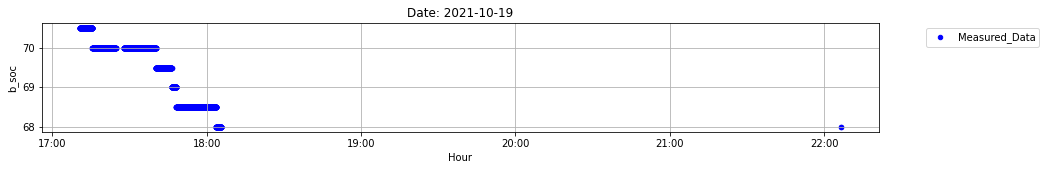

<Figure size 1080x144 with 0 Axes>

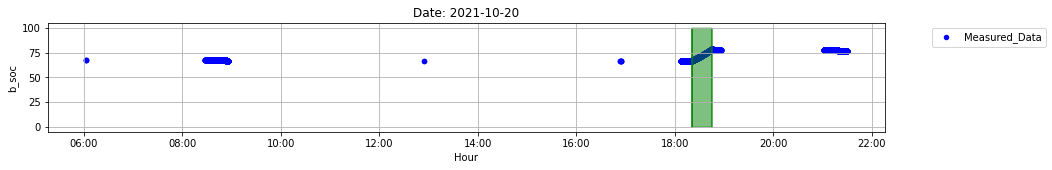

<Figure size 1080x144 with 0 Axes>

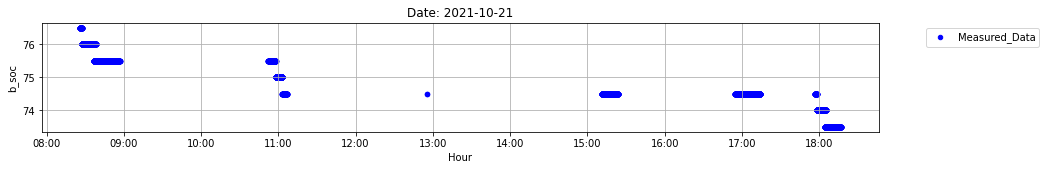

<Figure size 1080x144 with 0 Axes>

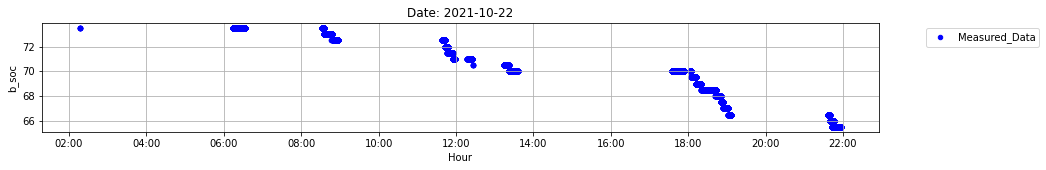

<Figure size 1080x144 with 0 Axes>

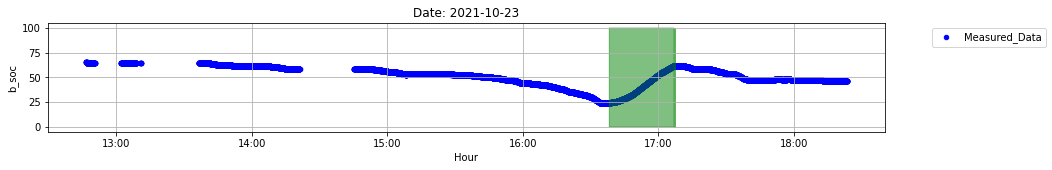

<Figure size 1080x144 with 0 Axes>

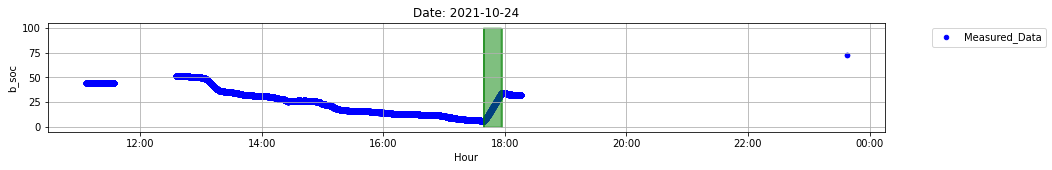

<Figure size 1080x144 with 0 Axes>

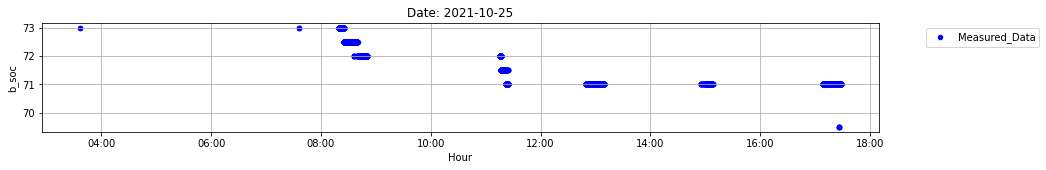

<Figure size 1080x144 with 0 Axes>

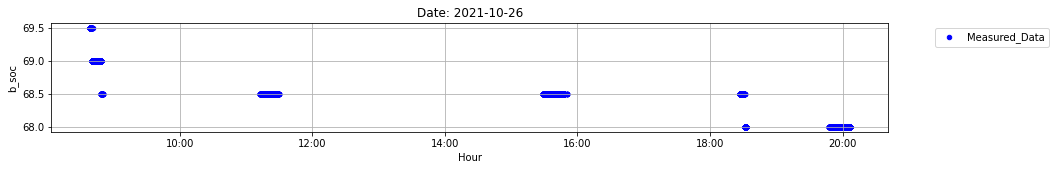

<Figure size 1080x144 with 0 Axes>

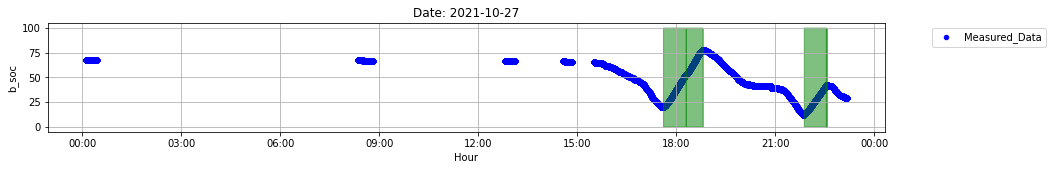

<Figure size 1080x144 with 0 Axes>

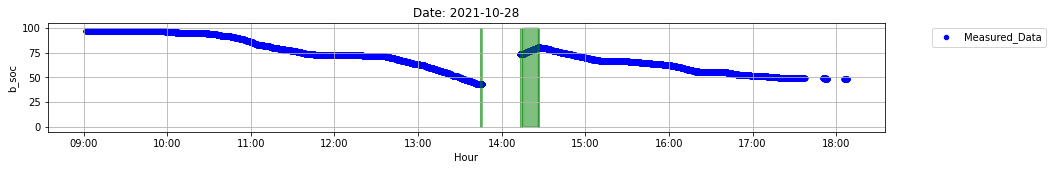

<Figure size 1080x144 with 0 Axes>

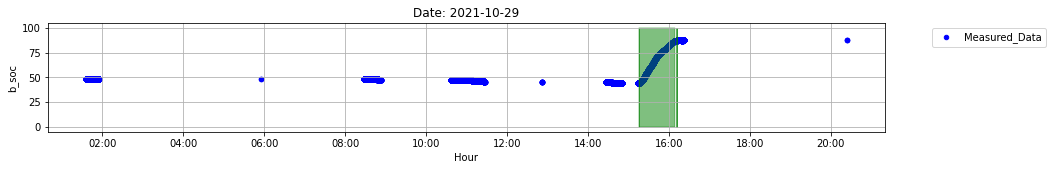

<Figure size 1080x144 with 0 Axes>

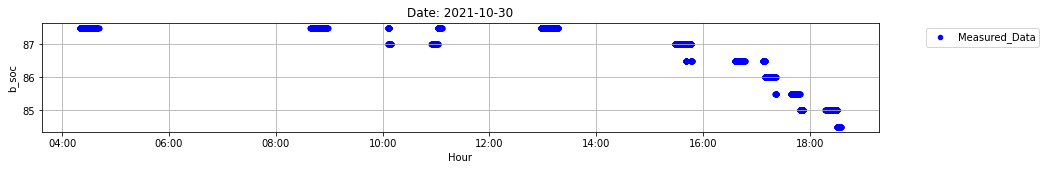

<Figure size 1080x144 with 0 Axes>

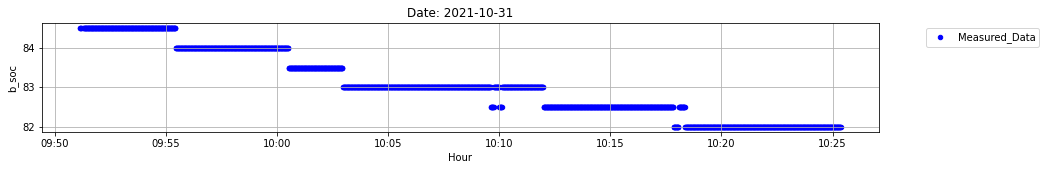

<Figure size 1080x144 with 0 Axes>

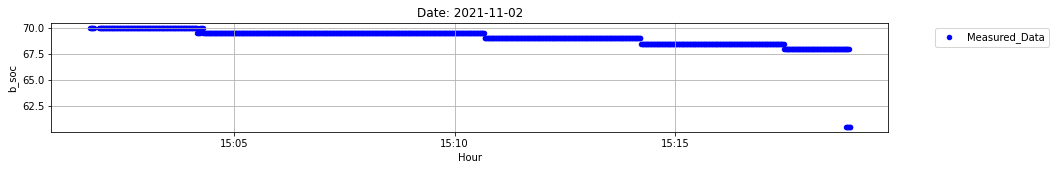

<Figure size 1080x144 with 0 Axes>

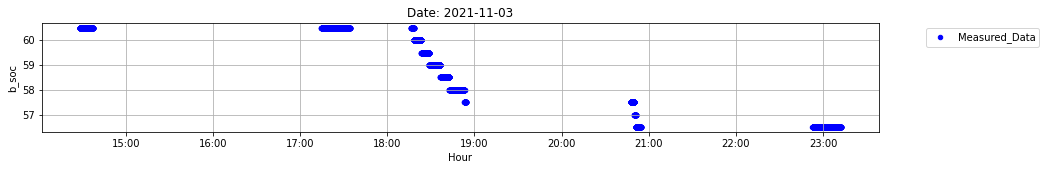

<Figure size 1080x144 with 0 Axes>

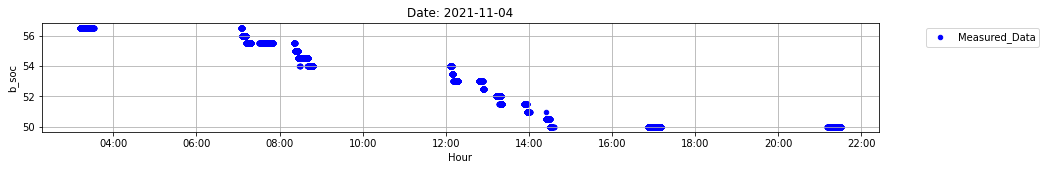

<Figure size 1080x144 with 0 Axes>

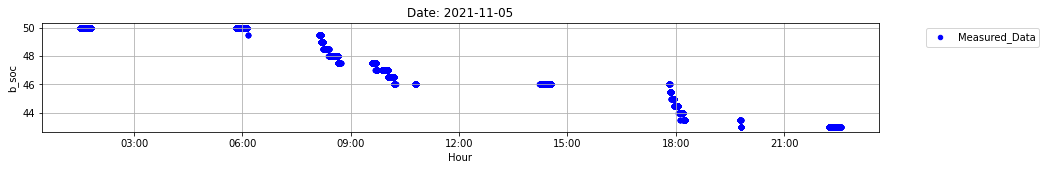

<Figure size 1080x144 with 0 Axes>

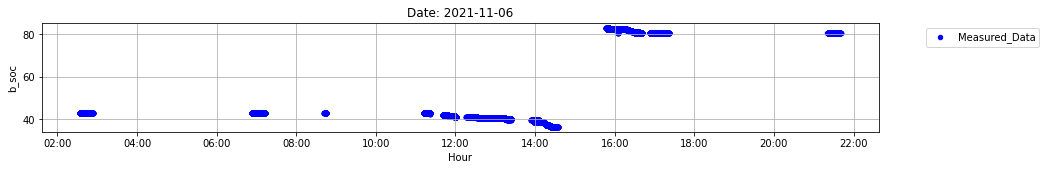

<Figure size 1080x144 with 0 Axes>

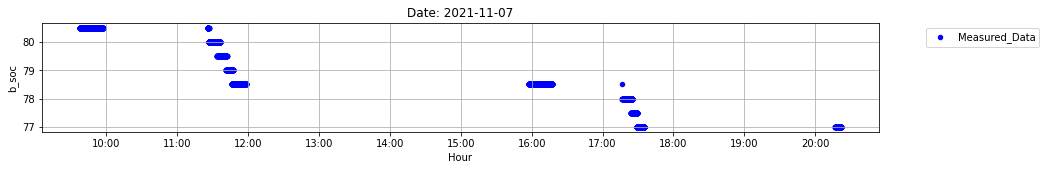

<Figure size 1080x144 with 0 Axes>

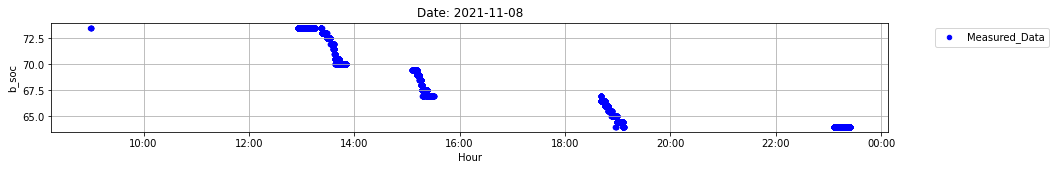

<Figure size 1080x144 with 0 Axes>

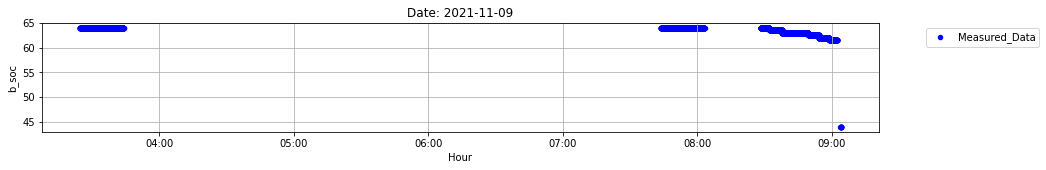

<Figure size 1080x144 with 0 Axes>

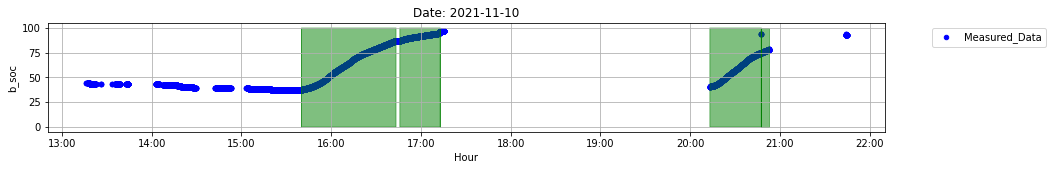

<Figure size 1080x144 with 0 Axes>

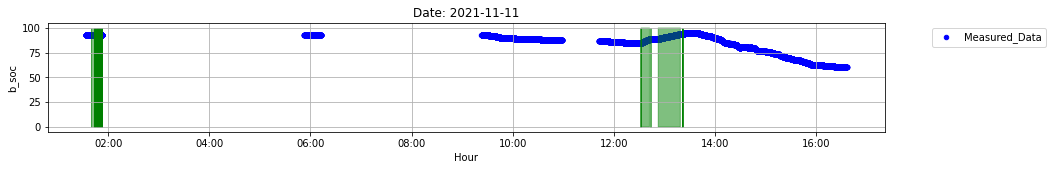

<Figure size 1080x144 with 0 Axes>

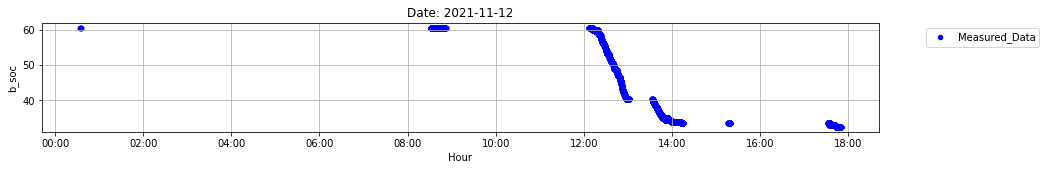

<Figure size 1080x144 with 0 Axes>

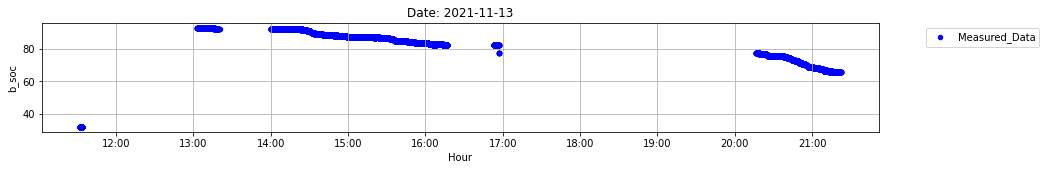

<Figure size 1080x144 with 0 Axes>

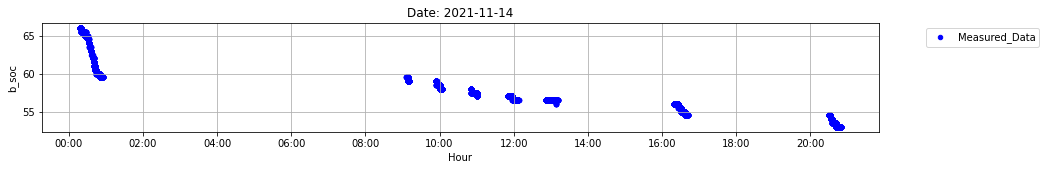

<Figure size 1080x144 with 0 Axes>

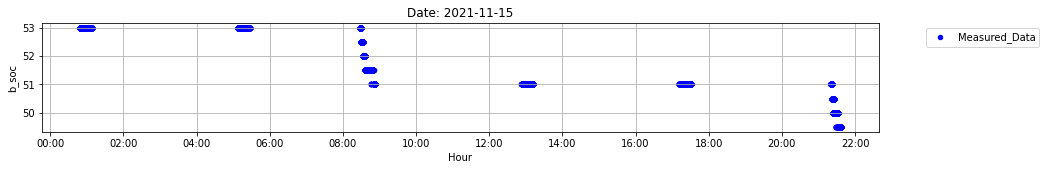

<Figure size 1080x144 with 0 Axes>

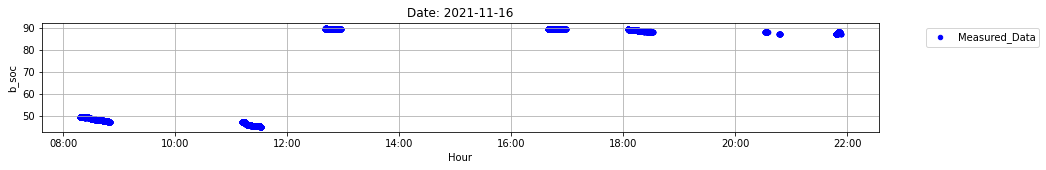

<Figure size 1080x144 with 0 Axes>

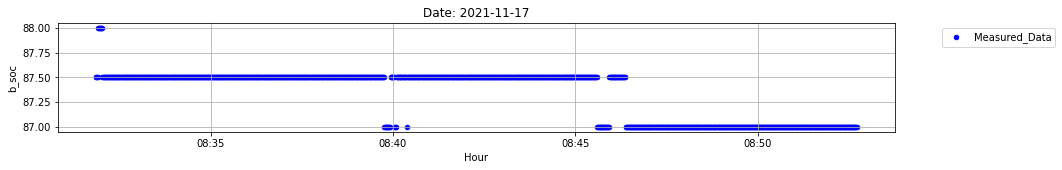

<Figure size 1080x144 with 0 Axes>

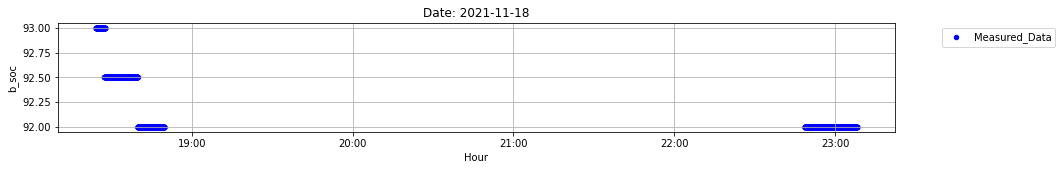

<Figure size 1080x144 with 0 Axes>

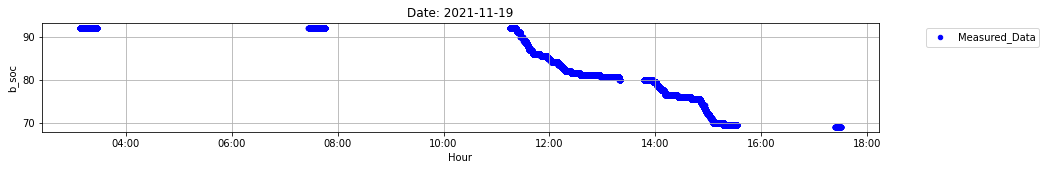

<Figure size 1080x144 with 0 Axes>

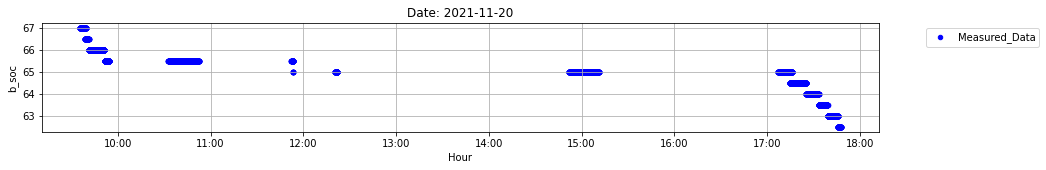

<Figure size 1080x144 with 0 Axes>

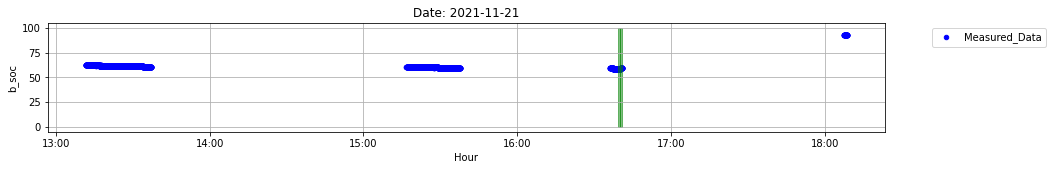

<Figure size 1080x144 with 0 Axes>

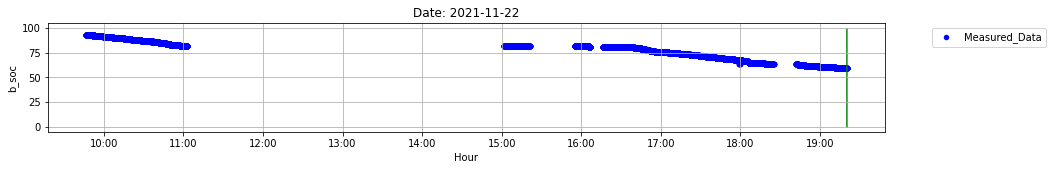

<Figure size 1080x144 with 0 Axes>

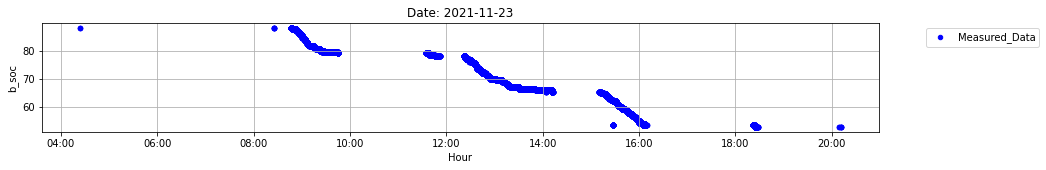

<Figure size 1080x144 with 0 Axes>

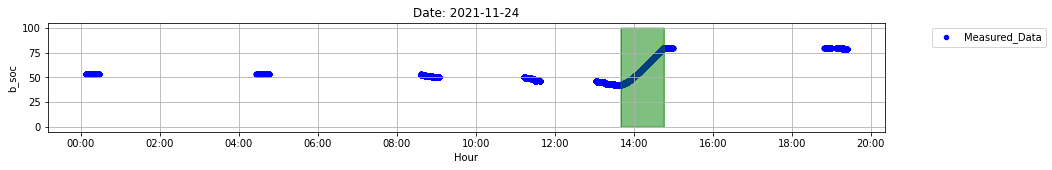

<Figure size 1080x144 with 0 Axes>

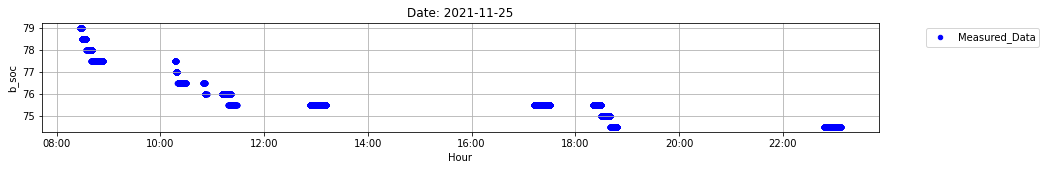

<Figure size 1080x144 with 0 Axes>

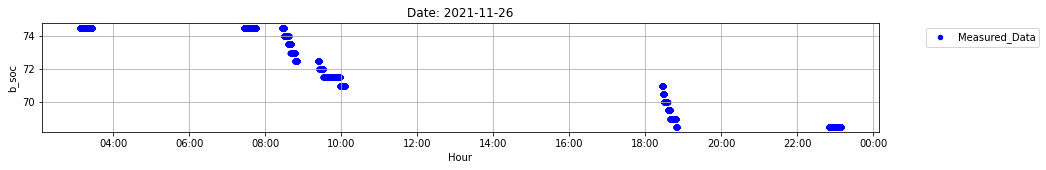

<Figure size 1080x144 with 0 Axes>

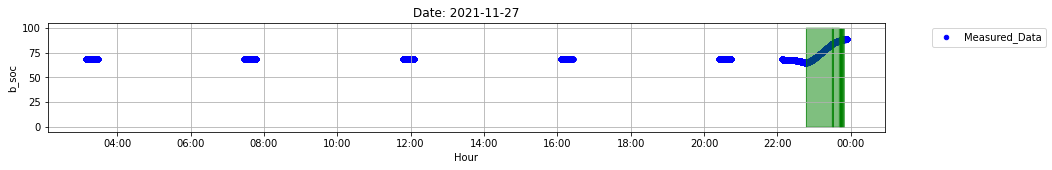

<Figure size 1080x144 with 0 Axes>

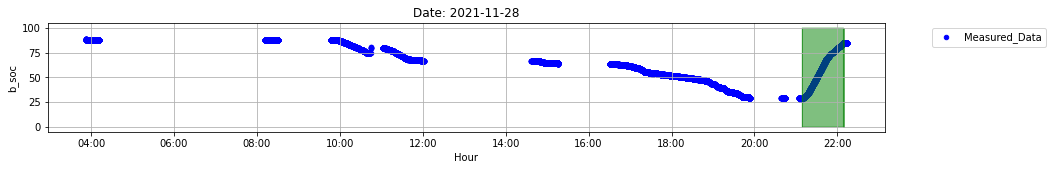

<Figure size 1080x144 with 0 Axes>

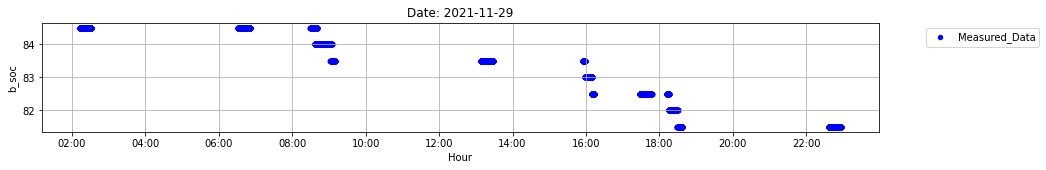

<Figure size 1080x144 with 0 Axes>

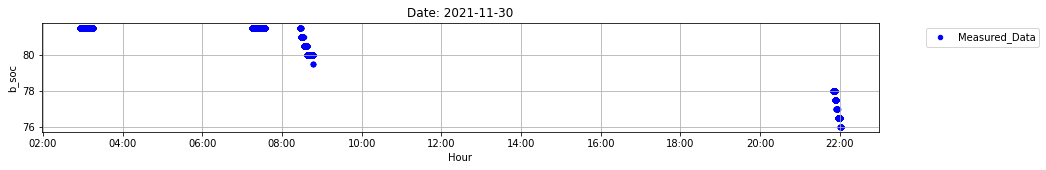

<Figure size 1080x144 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator
import datetime

# ts 필드가 YYYY-MM-DD HH:MM:SS 형태일 경우, 날짜만 추출
if(len(concat_df[ts][0])) == 19:
    concat_df['Date'] = concat_df[ts].str.slice(stop=10)
    date_list = concat_df['Date'].unique()
    concat_df['Hour'] = pd.to_datetime(concat_df[ts], format='%Y-%m-%d %H:%M:%S')
    
    '''
          # 날짜 별, 예측/판단 결과 그래프 출력
    '''
    for date in date_list:
        plt.rcParams["figure.figsize"] = (15, 2)
        each_date_df = concat_df[concat_df['Date']==date]
        each_date_df.plot.scatter(x='Hour', y='b_soc', color='blue', label='Measured_Data')
        
        lg = plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
        plt.title('Date: ' + date)
        plt.grid(True)
        ax = plt.gca()
        formatter = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(formatter)

        ##########################################################
        # 예측/판단결과 그래프 표시 설정 (색상, 범위, 두께 등)
        plt.fill_between(each_date_df['Hour'], 0, 100, where=each_date_df['pred_result']==1, color='green', alpha=0.5)
        ##########################################################

        plt.show()
        
        if not os.path.isdir('./result'):
            os.mkdir('./result')
        graph_path = './result/result_'+date+'.png'

        plt.savefig(
            graph_path, 
            bbox_extra_artists=(lg,), 
            bbox_inches='tight'
            )